In [475]:
%matplotlib inline
%config InlineBackend.figure_format='svg'
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import pandas as pd
import os

from operator import attrgetter
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from os.path import isfile, join

asdf

In [476]:
# These functions are used for data analysis.

# these functions are used in determining the type
# of data we are looking at (posthresh, neghold etc)
def is_increasing(L):
    return L[0] < L[len(L) - 1] and len(L) > 1
def is_decreasing(L):
    return L[0] > L[len(L) - 1] and len(L) > 1
def non_increasing(L):
    return all(x>=y for x, y in zip(L, L[1:]))
def non_decreasing(L):
    return all(x<=y for x, y in zip(L, L[1:]))
def monotonic(L):
    return non_increasing(L) or non_decreasing(L)
def average(array):
    return sum(array) / len(array)

# this will return the type of data you give it
# it takes an array of voltages and currents as arguments
def sort_into_side(voltage, current):
    if is_increasing(voltage) and is_increasing(current):
        return "posThresh"
    elif is_decreasing(voltage) and is_decreasing(current):
        return "posHold"
    elif is_decreasing(voltage) and is_increasing(current):
        return "negThresh"
    elif is_increasing(voltage) and is_decreasing(current):
        return "negHold"
    else: 
        print("???")
        # print("error determining type of data. V: ", voltage, " I: ", current)

def get_rand_id():
    return np.random.randint(1000000000)

def get_default(value, delfault):
    return value if value is not None else delfault

asdf

In [477]:
class Graph: 
    def __init__(self, title, xlabel, ylabel, hlines, type_of_graph, data_to_graph, points):
        # print(props)
        self.size = [18, 6]
        self.title = title
        self.xlabel = xlabel
        self.ylabel = ylabel
        self.hlines = hlines
        self.type = type_of_graph
        self.data_to_graph = data_to_graph
        self.points = points

        self.color_pool = ['blue', 'red', 'orange', 'green']

    def show(self):
        plt.rcParams['figure.figsize'] = (self.size[0], self.size[1])
        plt.title(self.title)
        plt.xlabel(self.xlabel)
        plt.ylabel(self.ylabel)
        plt.grid()

        if self.type == "semilogy":
            for i in range(len(self.data_to_graph) - 0):
                plt.semilogy(self.data_to_graph[i][0], self.data_to_graph[i][1], color=self.color_pool[i])

        for i in range(len(self.hlines)):
            plt.axhline(y = self.hlines[i], color = 'r', linestyle = '-')

        for i in range(len(self.points)):
            plt.plot(self.points[i][0], self.points[i][1], marker="o", markersize=10, markeredgecolor=self.color_pool[i], markerfacecolor=self.color_pool[i])
            
        plt.figure(get_rand_id())
        plt.show()

asdf

In [478]:
# this will take a file name
# get all of the meaningful stuff out of it
class DataFile:
    def __init__(self, file_path):
        self.pos_hold_voltages = []
        self.neg_hold_voltages = []

        self.pos_thresh_voltages = []
        self.neg_thresh_voltages = []
        self.filePath = file_path
        self.get_file_name_from_path()
        self.get_device_number_from_name()
        self.get_sample_number_from_name()
        self.read_all_data()
        self.break_all_data_into_IV_curves()
        self.sort_data_into_types()

    def get_file_name_from_path(self):
        self.file_name = self.filePath.split("/GitHub/")[1]

    def get_device_number_from_name(self):
        self.device_number = self.file_name.split("_")[4]

    def get_sample_number_from_name(self):
        self.sample_number = self.file_name.split("_")[3]

    def read_all_data(self):
        # REMOVE BAD DATA: read all the data and remove the rows when we are very close to the max current
        rows_to_exclude = pd.read_csv(self.filePath, names=['Time (s)','Current (A)','Voltage (V)', 'Temperature (K)'], sep='\t',skiprows=1)
        data = rows_to_exclude.values
        rows_to_exclude.head()
        I_to_skip = data[:,1]
        # the cut off value for the max current is 0.9999999 * the highest current recorded in the file
        self.max_current = np.max(I_to_skip) * 0.9999999
        print("max current: ", self.max_current)
        over_max_current_indexes = ((I_to_skip > self.max_current).nonzero())[0]


        # read the file again without the rows that have a current above the threshold
        df5 = pd.read_csv(self.filePath, names=['Time (s)','Current (A)','Voltage (V)', 'Temperature (K)'], sep='\t',skiprows=over_max_current_indexes)
        data = df5.values
        df5.head()
        
        self.number_of_data_points = len(data[:,0])
        print("number of data points: ", self.number_of_data_points)
        
        # self.time = data[:,0]
        interval = average(np.gradient(data[:,0][1:5]))
        # interval = 1
        self.time = np.arange(0, len(data[:,0])) * interval

        self.I = data[:,1]
        self.V = data[:,2]
        self.temps = data[:,3]

        self.R = self.V / self.I
        self.R = np.abs(self.R)

    def graph_all_data(self):
        the_graph = Graph(
            "All Data",         # title
            "Voltage (V)",      # xlabel
            "Current (A)",      # ylabel
            [self.max_current], # hlines
            "semilogy",         # type of graph
            [[self.V, self.I]],   # data to graph
            [],                 # points
        )
        the_graph.show()

    def break_all_data_into_IV_curves(self):
        # get the index of every "0" value in the voltage array
        self.all_zero_indexes = np.where(self.V == 0.0)[0]

        # removing the frist and last 4 reduces the number of crashes
        self.all_zero_indexes = self.all_zero_indexes[4:]
        self.all_zero_indexes = self.all_zero_indexes[:-4]

        self.IV_curves = []
        self.all_data_in_runs = []
        for i in range(len(self.all_zero_indexes) - 1):
            start = self.all_zero_indexes[i]
            stop = (int)(start + ((self.all_zero_indexes[i+1] - start) / 2))

            dI = np.gradient(self.I[start:stop])
            ddI = np.gradient(np.gradient(self.I[start:stop]))
            run_temp = np.average(self.temps[start:stop])
            run_temp_std = np.std(self.temps[start:stop])
            self.IV_curves.append({
                'time': self.time[start:stop],
                'I': self.I[start:stop],
                'dI': dI,
                'ddI': ddI,
                'V': self.V[start:stop],
                'temps': self.temps[start:stop],
                'temp': run_temp,
                'temp_std': run_temp_std,
                'type_of_data': sort_into_side(self.V[start:stop], self.I[start:stop]),
                'max_ddI': np.argmax(ddI),
            })

            start = (int)(self.all_zero_indexes[i] + ((self.all_zero_indexes[i+1] - start) / 2))
            stop = self.all_zero_indexes[i+1]

            dI = np.gradient(self.I[start:stop])
            ddI = np.gradient(np.gradient(self.I[start:stop]))
            run_temp = np.average(self.temps[start:stop])
            run_temp_std = np.std(self.temps[start:stop])
            self.IV_curves.append({
                'time': self.time[start:stop],
                'I': self.I[start:stop],
                'dI': dI,
                'ddI': ddI,
                'V': self.V[start:stop],
                'temps': self.temps[start:stop],
                'temp': run_temp,
                'temp_std': run_temp_std,
                'type_of_data': sort_into_side(self.V[start:stop], self.I[start:stop]),
                'max_ddI': np.argmax(ddI),
            })

        self.number_of_IV_curves = (len(self.IV_curves) - 1) * 1
        print("number of IV curves: ", self.number_of_IV_curves)

    def sort_data_into_types(self):
        pos_thresh_IV_curve_count = 0
        pos_hold_IV_curve_count = 0
        neg_thresh_IV_curve_count = 0
        neg_hold_IV_curve_count = 0

        for IV_curve in self.IV_curves:
            if IV_curve['type_of_data'] == "posThresh":
                pos_thresh_IV_curve_count += 1

            if IV_curve['type_of_data'] == "negThresh":
                neg_thresh_IV_curve_count += 1

            if IV_curve['type_of_data'] == "posHold":
                pos_hold_IV_curve_count += 1

            if IV_curve['type_of_data'] == "negHold":
                neg_hold_IV_curve_count += 1

        print("pos_thresh_IV_curve_count: ", pos_thresh_IV_curve_count)
        print("pos_hold_IV_curve_count: ", pos_hold_IV_curve_count)
        print("neg_thresh_IV_curve_count: ", neg_thresh_IV_curve_count)
        print("neg_hold_IV_curve_count: ", neg_hold_IV_curve_count)

    def graph_IV_curve(self, index):
        title_time = "  Time =" + str(round(self.IV_curves[index]['time'][0], 3)) + " s"
        title_temp = "  Temp =" + str((self.IV_curves[index]['temp'])) + " K" + " Std: " + str(round(self.IV_curves[index]['temp_std'], 3))
        title = "IV curve # " + str(index) + title_time + title_temp

        data_to_graph = []
        points_to_graph = []

        for i in range(4):
            voltage = self.IV_curves[index + i]['V']
            current = self.IV_curves[index + i]['I']
            data_to_graph.append([voltage, current])

            fine_tune = 0
            type_of_data = self.IV_curves[index + i]['type_of_data']
            if type_of_data == "posThresh":
                fine_tune = 1
            if type_of_data == "negThresh":
                fine_tune = 1
            if type_of_data == "posHold":
                fine_tune = -2
            if type_of_data == "negHold":
                fine_tune = -2
            
            index_to_graph = self.IV_curves[index + i]['max_ddI'] + fine_tune
            points_to_graph.append([voltage[index_to_graph], current[index_to_graph]])

        the_graph = Graph(
            title,              # title
            "Voltage (V)",      # xlabel
            "Current (A)",      # ylabel
            [],                 # hlines
            "semilogy",         # type of graph
            data_to_graph,      # data to graph
            points_to_graph,    # points
        )
        the_graph.show()


    def graph_IV_curves(self, number_of_graphs):
        for x in range(0, number_of_graphs):
            i = (int)(((self.number_of_IV_curves) / number_of_graphs) * x)
            self.graph_IV_curve(i)


asdf

max current:  0.0020009427999056997
number of data points:  474831
number of IV curves:  5273
pos_thresh_IV_curve_count:  1321
pos_hold_IV_curve_count:  1319
neg_thresh_IV_curve_count:  1317
neg_hold_IV_curve_count:  1317


<Figure size 1800x600 with 0 Axes>

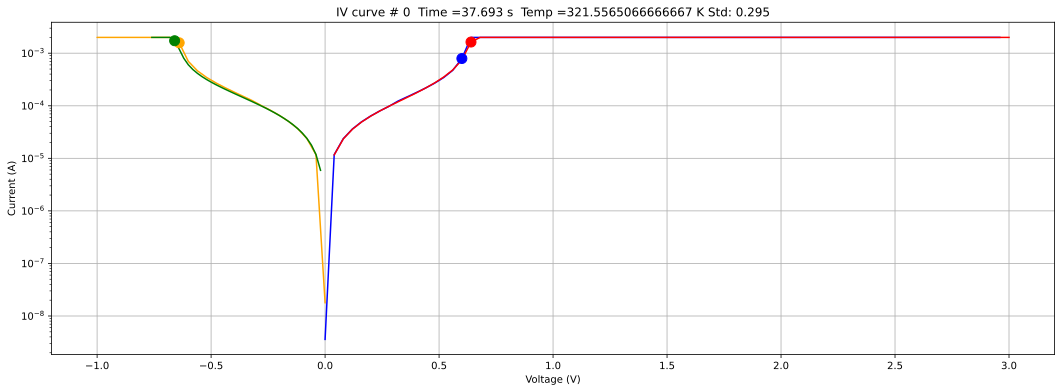

<Figure size 1800x600 with 0 Axes>

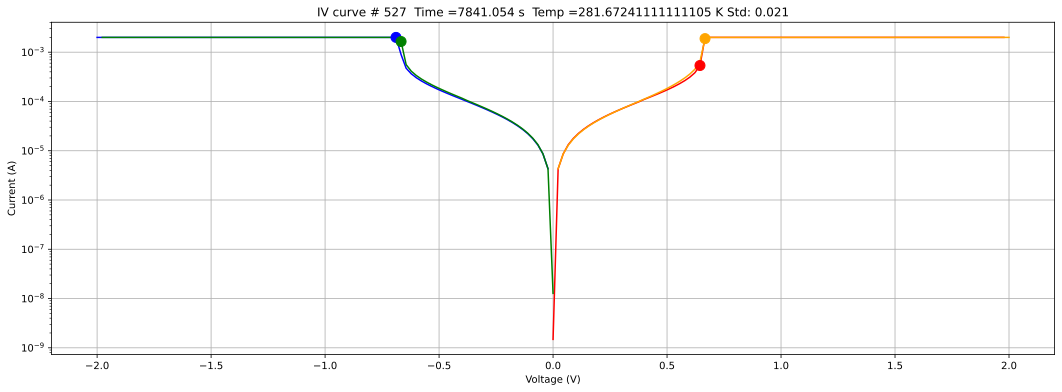

<Figure size 1800x600 with 0 Axes>

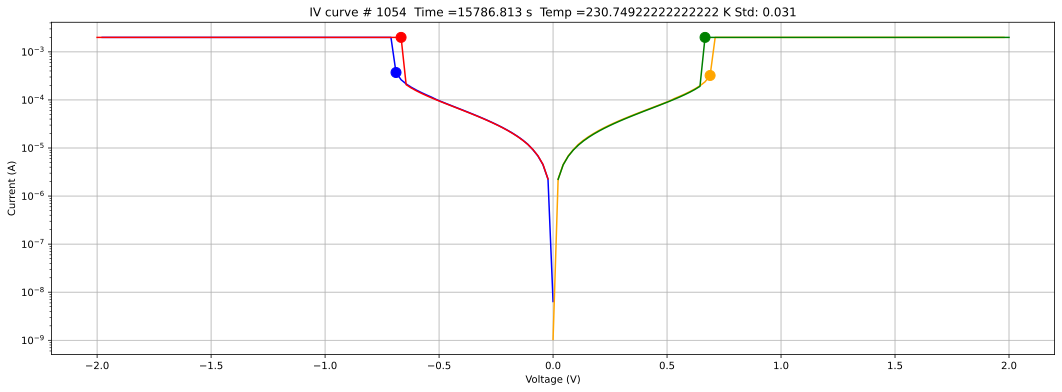

<Figure size 1800x600 with 0 Axes>

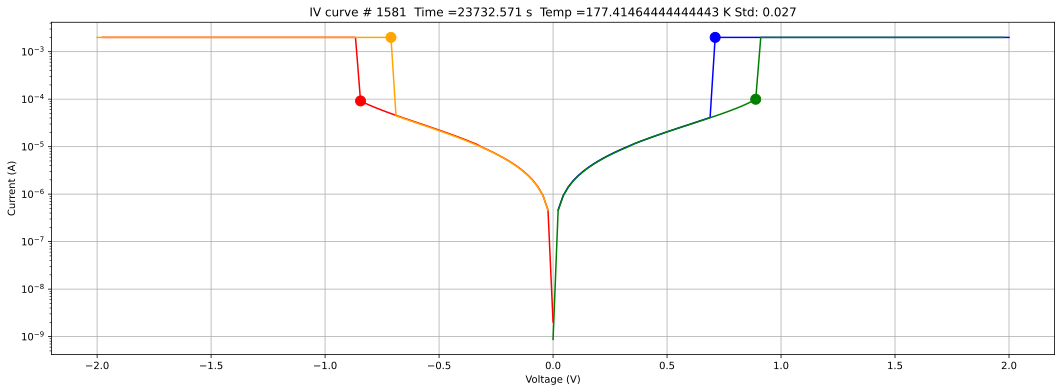

<Figure size 1800x600 with 0 Axes>

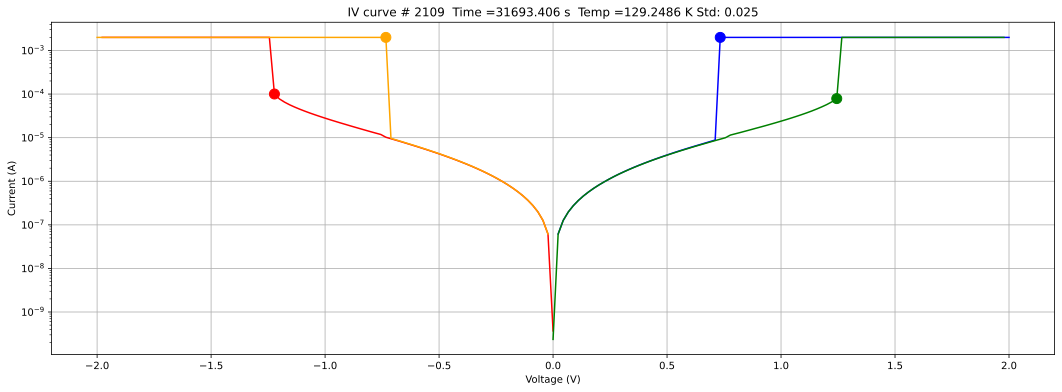

<Figure size 1800x600 with 0 Axes>

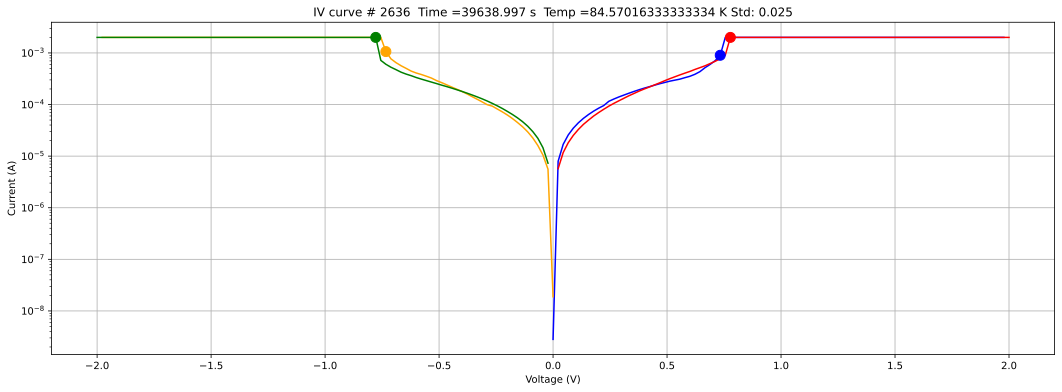

<Figure size 1800x600 with 0 Axes>

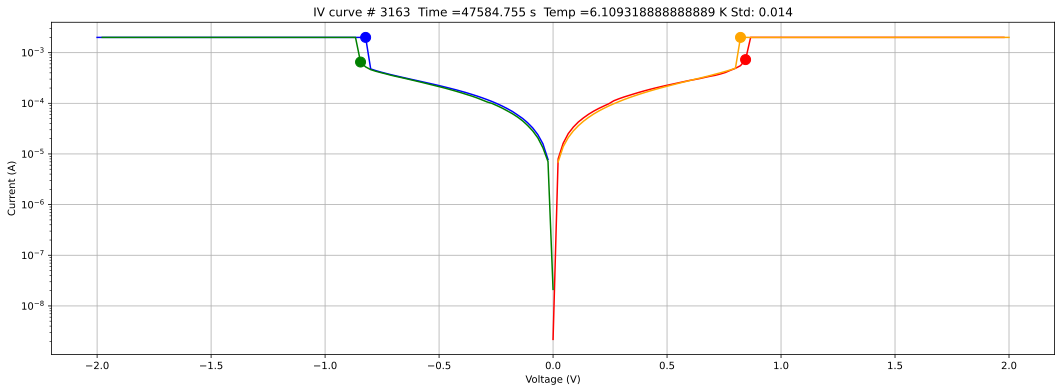

<Figure size 1800x600 with 0 Axes>

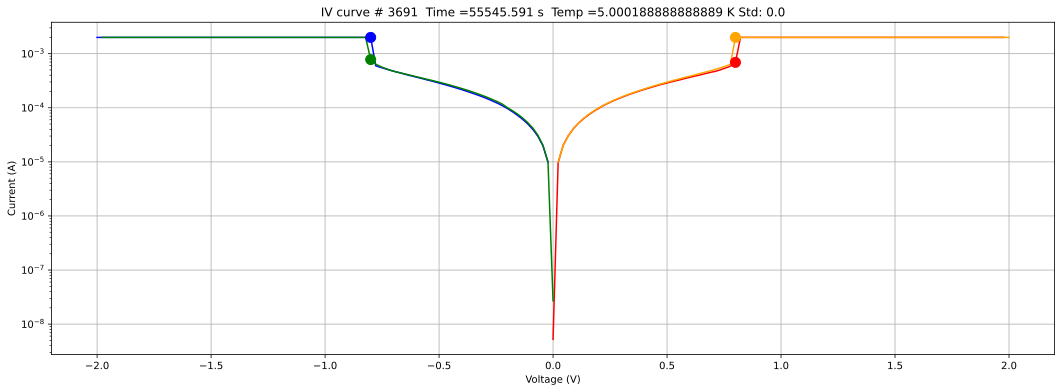

<Figure size 1800x600 with 0 Axes>

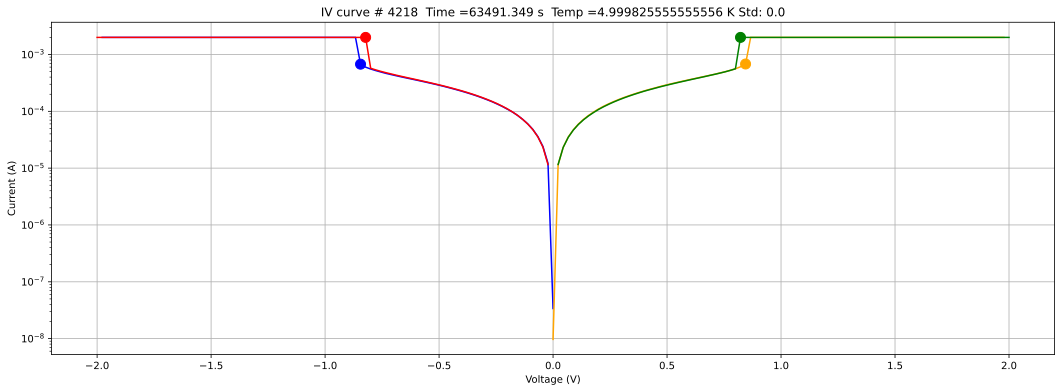

<Figure size 1800x600 with 0 Axes>

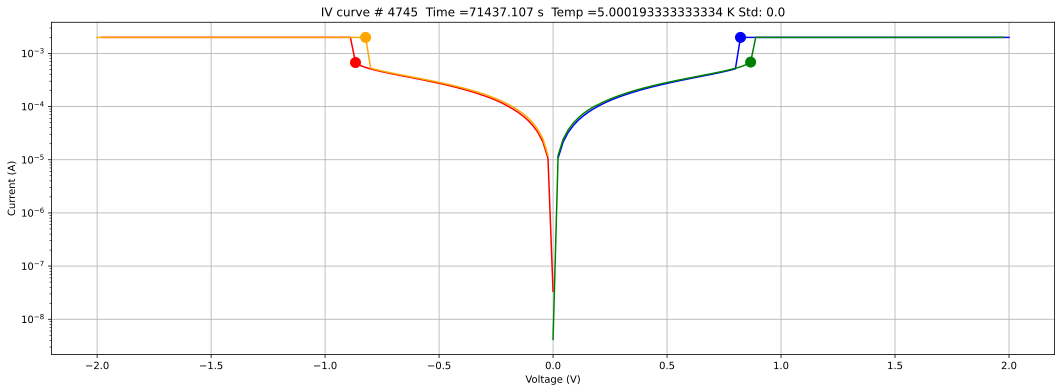

<Figure size 1800x600 with 0 Axes>

In [479]:
theFile = DataFile("c:/Users/Ted Mburu/Documents/GitHub/Nb02_v2/IVs_NbO2_Ti0_Sam3_052423_D15_cool.txt");
# theFile = DataFile(os.getcwd() + "/IVs_NbO2_Ti0_Sam3_052423_D15_cool.txt");

theFile.graph_all_data()
theFile.graph_IV_curves(10)